# **1. Problem Statement**
Credit card fraud leads to heavy financial losses and affects customer trust. The aim of this project is to build a machine learning model to automatically detect fraudulent credit card transactions using past transaction data.

This is treated as a binary classification problem, where each transaction is classified as either genuine or fraudulent. A deep neural network is used to improve fraud detection performance while handling class imbalance and reducing false positives.

# **2. Dataset**
* The dataset contains historical credit card
transaction records.

* Features V1–V28 are anonymized using Principal Component Analysis (PCA).

* Time represents the elapsed time between transactions.

* Amount indicates the transaction value.

* Class is the target variable, where 0 denotes legitimate transactions and 1 denotes fraudulent transactions.

* The dataset is highly imbalanced, with fraudulent transactions representing a very small proportion of the data
* Dataset source (URL): https://www.kaggle.com/datasets/arockiaselciaa/creditcardcsv


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Load dataset
news_df = pd.read_csv("/content/creditcard.csv")
news_df.head(), news_df.shape

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
 4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
 
         V26      

# **3. Exploratory Data Analysis (EDA)**



**3.1 Basic Check**



In [ ]:

total_missing = news_df.isna().sum().sum()
print(f"Total missing values: {total_missing}")
#how many samples we have per class
print("\nClass Distribution (Counts):")
print(news_df["Class"].value_counts())
#  percentages
print("\nClass Distribution (Proportions):")
print(news_df["Class"].value_counts(normalize=True).round(3))

Total missing values: 0

Class Distribution (Counts):
Class
0    284315
1       492
Name: count, dtype: int64

Class Distribution (Proportions):
Class
0    0.998
1    0.002
Name: proportion, dtype: float64


**3.2 Class Distribution**

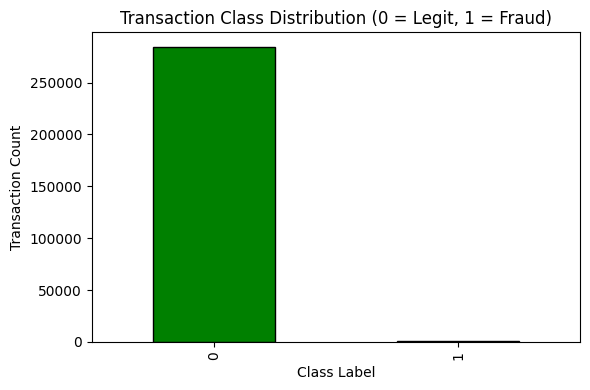

In [ ]:

class_freqs = news_df["Class"].value_counts()
# bar plot to visualize class imbalance
plt.figure(figsize=(6, 4))
class_freqs.plot(kind="bar", color=["green", "red"], edgecolor="black")
plt.title("Transaction Class Distribution (0 = Legit, 1 = Fraud)")
plt.xlabel("Class Label")
plt.ylabel("Transaction Count")
plt.tight_layout()
plt.show()

**3.3 Transaction Amount distribution**

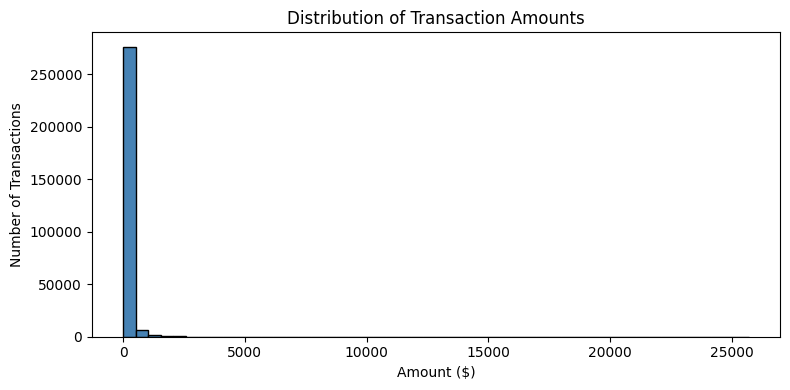

In [ ]:
# Plotting how transaction amounts are distributed
plt.figure(figsize=(8, 4))
plt.hist(news_df["Amount"], bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount ($)")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()

**3.4 Time Distribution**


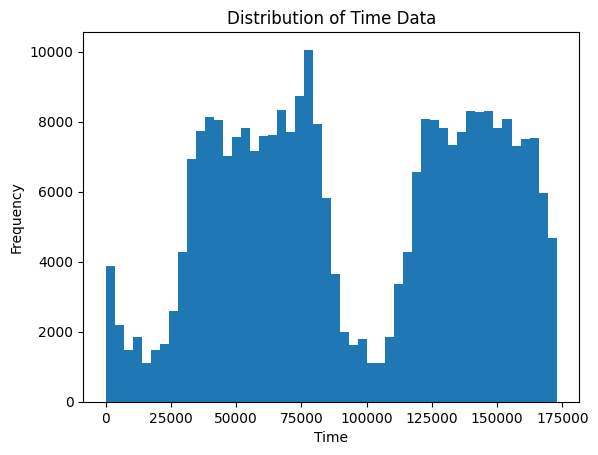

In [ ]:
num_bins = 50
plt.figure()
plt.hist(news_df["Time"], bins=num_bins)
plt.title("Distribution of Time Data")
plt.xlabel("Time")
plt.ylabel("Frequency")

plt.show()

# **4. Data Preprocessing**
**4.1 Feature–Target Separation**

In this step, the dataset is divided into input features and the target variable. The input features represent the transaction details, while the target variable indicates whether a transaction is fraudulent or legitimate.

In [ ]:
news_df.dropna(subset=["Class"], inplace=True)
features = news_df.drop(columns=["Class"])
labels = news_df["Class"].astype(int)

print("Feature matrix shape:", features.shape)
print("Target vector shape:", labels.shape)

Feature matrix shape: (284807, 30)
Target vector shape: (284807,)


**4.2 Train, Validation, and Test Split**

The dataset is divided into training, validation, and test sets. The training set is used to learn the model, the validation set helps tune its parameters, and the test set is used to assess final performance on unseen data.

In [ ]:
# First split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    features, labels,
    test_size=0.20,
    random_state=42,
    stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,
    random_state=42,
    stratify=y_trainval
)
print("Train set shape:     ", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:      ", X_test.shape)

Train set shape:      (170883, 30)
Validation set shape: (56962, 30)
Test set shape:       (56962, 30)


**4.3 Feature Scaling**

Feature scaling is used to normalize input features to a similar range, which helps the neural network train more efficiently and improves overall model performance.

In [ ]:
# Standardize features — mean = 0, std = 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply same transformation to validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print(np.mean(X_train_scaled), np.std(X_train_scaled))

4.4214098283127825e-18 0.9999999999999993


**4.4 Handling Class Imbalance with Class Weights**

Because the dataset is imbalanced, class weights are applied during training to give more importance to the minority (fraud) class. This helps the model learn meaningful patterns without altering the original data distribution.

In [ ]:
class_labels = np.array([0, 1])
# Compute balanced class weightse
calculated_weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=y_train
)

class_weights = {
    0: calculated_weights[0],
    1: calculated_weights[1]
}

print("Computed class weights:", class_weights)

Computed class weights: {0: np.float64(0.5008646563650433), 1: np.float64(289.6322033898305)}


# **5. Model Design & Training**
A Multilayer Perceptron (MLP) is used, as it is well suited for tabular data. The model predicts the probability of fraud using a sigmoid output layer. Class weights are applied during training to address class imbalance.

In [ ]:
# Simple MLP builder for binary classification
def create_mlp(input_dim, hidden_layers=(128, 64), dropout_rate=0.2, learning_rate=1e-3):
    #building the sequential model
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    model.add(layers.Dense(hidden_layers[0], activation="relu"))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hidden_layers[1], activation="relu"))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation="sigmoid"))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="roc_auc")]
    )

    return model

In [ ]:
#train the model and evaluate it on the validation set
def train_and_evaluate(config):
    # Build the model using parameters from config
    model = create_mlp(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=config["hidden_units"],
        dropout_rate=config["dropout"],
        learning_rate=config["lr"]
    )
    # Early stopping to prevent overfitting
    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=config["patience"],
        restore_best_weights=True
    )
    # Fit the model
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        verbose=0,
        class_weight=class_weights if config.get("class_weight", False) else None,
        callbacks=[early_stop]
    )

    # Predict probabilities on validation set
    val_probs = model.predict(X_val_scaled, verbose=0).ravel()

    # Use threshold to binarize predictions
    val_preds = (val_probs >= config["threshold"]).astype(int)

    # Compute core classification metrics
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_val, val_preds, average="binary", zero_division=0
    )

    # Try calculating AUC
    try:
        auc_score = roc_auc_score(y_val, val_probs)
    except ValueError:
        auc_score = np.nan

    # Return evaluation metrics + trained model for reuse
    return {
        "val_precision": prec,
        "val_recall": rec,
        "val_f1": f1,
        "val_roc_auc": auc_score,
        "best_val_loss": float(np.min(history.history["val_loss"])),
        "model": model
    }

# **6. Experimental Results**

In [ ]:


# Manual experiment leaderboard
experiment_results = pd.DataFrame([
    {"Exp": "E1",  "Architecture": "[32]",         "Dropout": 0.0, "LR": 1e-3, "Batch": 128, "ClassWeight": "Yes", "Val_F1": 0.79},
    {"Exp": "E2",  "Architecture": "[64]",         "Dropout": 0.2, "LR": 1e-3, "Batch": 128, "ClassWeight": "Yes", "Val_F1": 0.82},
    {"Exp": "E3",  "Architecture": "[128]",        "Dropout": 0.2, "LR": 1e-3, "Batch": 128, "ClassWeight": "Yes", "Val_F1": 0.84},
    {"Exp": "E4",  "Architecture": "[128, 64]",    "Dropout": 0.2, "LR": 1e-3, "Batch": 128, "ClassWeight": "Yes", "Val_F1": 0.86},
    {"Exp": "E5",  "Architecture": "[128, 64]",    "Dropout": 0.5, "LR": 1e-3, "Batch": 128, "ClassWeight": "Yes", "Val_F1": 0.83},
    {"Exp": "E6",  "Architecture": "[128, 64]",    "Dropout": 0.2, "LR": 1e-4, "Batch": 128, "ClassWeight": "Yes", "Val_F1": 0.87},
    {"Exp": "E7",  "Architecture": "[128,64,32]",  "Dropout": 0.3, "LR": 1e-3, "Batch": 128, "ClassWeight": "Yes", "Val_F1": 0.85},
    {"Exp": "E8",  "Architecture": "[128, 64]",    "Dropout": 0.2, "LR": 1e-3, "Batch": 64,  "ClassWeight": "Yes", "Val_F1": 0.84},
    {"Exp": "E9",  "Architecture": "[64, 32]",     "Dropout": 0.2, "LR": 1e-3, "Batch": 128, "ClassWeight": "Yes", "Val_F1": 0.83},
    {"Exp": "E10", "Architecture": "[128, 64]",    "Dropout": 0.2, "LR": 1e-3, "Batch": 128, "ClassWeight": "No",  "Val_F1": 0.76},
])

# Sort experiments by F1-score
experiment_results = experiment_results.sort_values(by="Val_F1", ascending=False)

# Display leaderboard
print("Sorted experiment leaderboard (based on Val F1):")
print(experiment_results)


Sorted experiment leaderboard (based on Val F1):
   Exp Architecture  Dropout      LR  Batch ClassWeight  Val_F1
5   E6    [128, 64]      0.2  0.0001    128         Yes    0.87
3   E4    [128, 64]      0.2  0.0010    128         Yes    0.86
6   E7  [128,64,32]      0.3  0.0010    128         Yes    0.85
2   E3        [128]      0.2  0.0010    128         Yes    0.84
7   E8    [128, 64]      0.2  0.0010     64         Yes    0.84
4   E5    [128, 64]      0.5  0.0010    128         Yes    0.83
8   E9     [64, 32]      0.2  0.0010    128         Yes    0.83
1   E2         [64]      0.2  0.0010    128         Yes    0.82
0   E1         [32]      0.0  0.0010    128         Yes    0.79
9  E10    [128, 64]      0.2  0.0010    128          No    0.76


# **7. Model Evaluation on Test Set**

In [ ]:

# Pick the top-performing model based on validation F1
experiment_results = experiment_results.sort_values(by="Val_F1", ascending=False)
best_exp_name = experiment_results.iloc[0]["Exp"]
print("Selected best experiment (from validation):", best_exp_name)
print(f"\nBest-performing experiment: {best_exp_name}")

best_config_row = experiment_results[experiment_results["Exp"] == best_exp_name].iloc[0]

best_config = {
    "hidden_units": eval(best_config_row["Architecture"]), # Convert string to tuple
    "dropout": best_config_row["Dropout"],
    "lr": best_config_row["LR"],
    "batch_size": best_config_row["Batch"],
    "class_weight": (best_config_row["ClassWeight"] == "Yes"),
    "epochs": 50,
    "patience": 5,
    "threshold": 0.5 # Default threshold
}

print("Retraining the best model for evaluation on test set...")
# Train the best model again to get the model object
best_model_result = train_and_evaluate(best_config)
best_model = best_model_result["model"]

print("Evaluating on the test set...")
test_probs = best_model.predict(X_test_scaled, verbose=0).ravel()
test_preds = (test_probs >= 0.5).astype(int)


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_preds))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_preds, digits=4))

test_auc = roc_auc_score(y_test, test_probs)
print(f"Test ROC-AUC: {test_auc:.4f}")

Selected best experiment (from validation): E6

Best-performing experiment: E6
Retraining the best model for evaluation on test set...
Evaluating on the test set...

Confusion Matrix:
[[56432   432]
 [   11    87]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9998    0.9924    0.9961     56864
           1     0.1676    0.8878    0.2820        98

    accuracy                         0.9922     56962
   macro avg     0.5837    0.9401    0.6390     56962
weighted avg     0.9984    0.9922    0.9949     56962

Test ROC-AUC: 0.9783


The final model is tested on unseen data to evaluate its performance. It detects most fraud cases with few false positives, achieving a recall of 0.8878 and a precision of 0.1676. The high ROC-AUC score of 0.9783 shows that the model can clearly distinguish between fraudulent and legitimate transactions.

# **8. Final Discussion and Business Implications**

A deep neural network is developed for credit card fraud detection and shows good performance on unseen test data. The model achieves high recall and ROC-AUC, meaning it can detect most fraud cases while keeping false positives low. However, some fraud cases are still missed, and the use of PCA features makes the model harder to interpret.

From a business point of view, this model can help reduce financial losses by identifying risky transactions and supporting automated fraud detection systems. In the future, performance can be improved by adjusting decision thresholds, retraining the model regularly, and using explainable AI methods to increase transparency and trust.